In [460]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [461]:
X, labels = make_moons(n_samples=5000, noise=0.2, random_state=42)
X = X[labels==0]

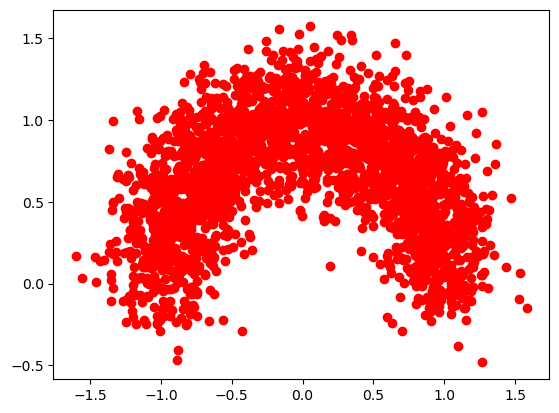

In [462]:
plt.plot(X[:, 0], X[:, 1], 'ro')
plt.show()

In [463]:
data = torch.tensor(X, dtype=torch.float32).to(device)

In [464]:
class Denoiser(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Denoiser, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = Denoiser(2, 2, 16).to(device)

In [465]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.model = model
        self.timesteps = timesteps
        self.reversed_time_steps = np.arange(self.timesteps)[::-1]
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def sample(self, num_samples):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32)
            for i, t in enumerate(self.reversed_time_steps):

                #TODO
                eps = self.model(x)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(np.sqrt(alpha_t))*(x-(beta_t/np.sqrt(1-alpha_t_cumprod))*eps)

                noise = torch.randn_like(x)
                x = mean + np.sqrt(beta_t) * noise
        return x

    def train(self, data, epochs=1000, batch_size=32, lr=1e-3):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
        losses = []

        for epoch in range(epochs):
            for batch in dataloader:
                optimizer.zero_grad()
                t = torch.randint(0, self.timesteps, (batch.size(0),), device=batch.device).long()
                noise = torch.randn_like(batch, dtype=torch.float32)
                noisy_data = torch.sqrt(self.alphas_cumprod[t]).view(-1, 1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t]).view(-1, 1) * noise
                predicted_noise = self.model(noisy_data)
                loss = criterion(predicted_noise, noise)
                loss.backward()
                optimizer.step()

            if epoch % 100 == 0:
                losses.append(loss.item())
                print(f'Epoch {epoch}, Loss: {loss.item()}')
        return losses
    
ddpm = DDPM(model, timesteps=5000)

In [466]:
losses = ddpm.train(data, epochs=1000)

Epoch 0, Loss: 0.5020138621330261
Epoch 100, Loss: 0.01573975756764412
Epoch 200, Loss: 0.09712344408035278
Epoch 300, Loss: 0.030624644830822945
Epoch 400, Loss: 0.00391120370477438
Epoch 500, Loss: 0.003652418963611126
Epoch 600, Loss: 0.6267727613449097
Epoch 700, Loss: 0.07222487032413483
Epoch 800, Loss: 0.0066099101677536964
Epoch 900, Loss: 0.01618187688291073


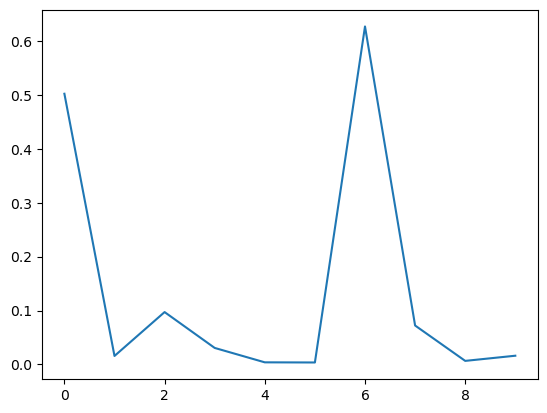

In [467]:
plt.plot(losses)
plt.show()

In [468]:
new_samples = ddpm.sample(num_samples=200).detach().numpy()

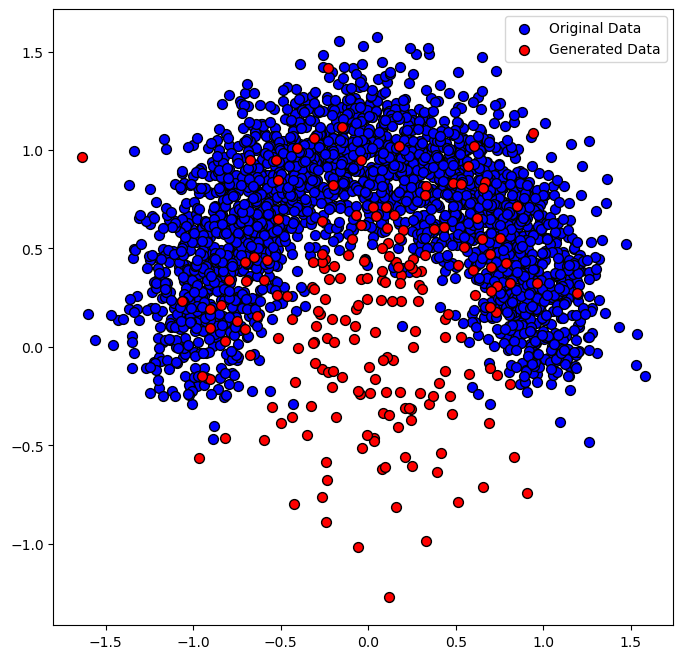

In [469]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
plt.show()